In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np

### TO DO

- try another architecture inception_4_400 	 0.204 

- and ensemble 293p
http://forums.fast.ai/t/dog-breed-identification-challenge/7464/293

- Cross Validation (64p 133p) http://forums.fast.ai/t/cross-validation-with-fast-ai/7988?u=sermakarevich

In [3]:
PATH = "data/dogbreed/"
# size of images 224x224
sz = 224
arch = resnext101_64
# batch size
bs = 58

In [4]:
!ls {PATH}

labels.csv	sample_submission.csv  test.zip  train
labels.csv.zip	test		       tmp	 train.zip


In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1

# Fast AI way of getting train/validation set (80/20): 
val_idxs = [get_cv_idxs(n)]

print("Validation set size is", len(val_idxs))

Validation set size is 1


### 2 Exploration

In [6]:
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# Exploring the number of images per breed.
# label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

In [8]:
# Enable data augmentation by using transforms_side_on for image we can flip only horizontally
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# Load data and setting to use test set for prediction/submission to Kaggle
data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

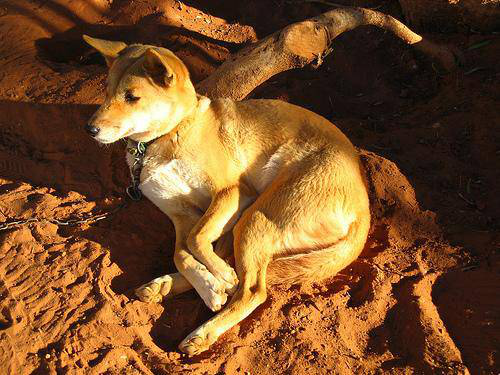

In [10]:
img = PIL.Image.open(fn); img

In [11]:
img.size

(500, 375)

In [12]:
# Create a dictionary mapping size of the file to its name
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [13]:
# Turn dictionary into rows and cols
row_sz, col_sz = list(zip(*size_d.values()))

row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

# row_sz[:5]

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

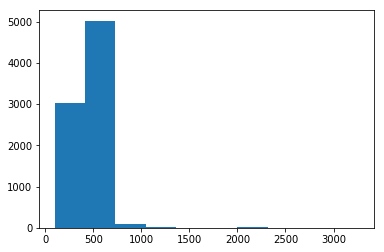

In [14]:
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

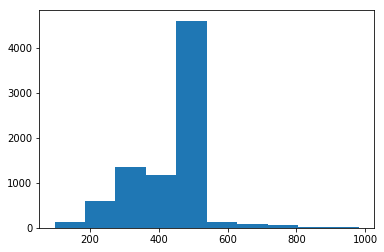

In [15]:
# Grab just images lesser than < 1000px
plt.hist(row_sz[row_sz < 1000])

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

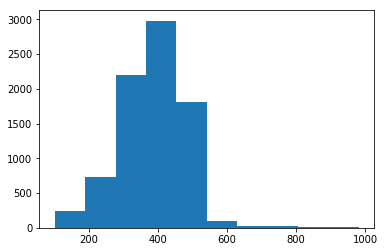

In [16]:
# The same for cols
plt.hist(col_sz[col_sz < 1000])

In [17]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [18]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

### Initial model

In [19]:
# Helps us itterate faster by changing images from small to big
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [20]:
# Load our data sets
%time data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
# Create our simple model, no data augmentation.
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 36/36 [00:26<00:00,  1.34it/s]


In [22]:
# Find the best learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 126/141 [00:01<00:00, 66.74it/s, loss=12]  


The plot shows Loss vs. Learning rate for the dataset. Now it is easy to choose an optimal range for learning rate before the curve flattens. Good article explaining this method : https://miguel-data-sc.github.io/2017-11-05-first/

In [23]:
# Training is very fast with precomputed weights
# Set lr to 0.01 as find in lr_find
learn.fit(1e-2,5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.935845   0.410049   0.901341  
    1      0.424744   0.30118    0.917146                    
    2      0.289159   0.322298   0.918582                    
    3      0.240088   0.32392    0.914272                    
    4      0.192551   0.304476   0.918103                    



[0.30447593, 0.918103449874454]

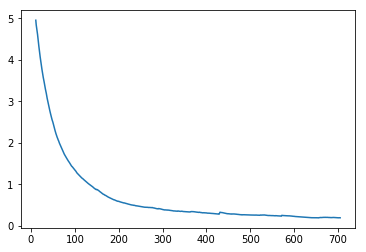

In [24]:
# Plot loss training
learn.sched.plot_loss()

In [25]:
# Usign cycle_len=1 means stochastic gradient descent with restarts used only once during the training.
learn.precompute = False
%time learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.248686   0.239893   0.92433   
    1      0.221402   0.235813   0.923372                    
    2      0.216761   0.230541   0.930556                    
    3      0.20224    0.232116   0.927682                    
    4      0.199722   0.228758   0.926245                    

CPU times: user 15min 27s, sys: 1min 2s, total: 16min 30s
Wall time: 10min 55s


[0.22875772, 0.926245210899247]

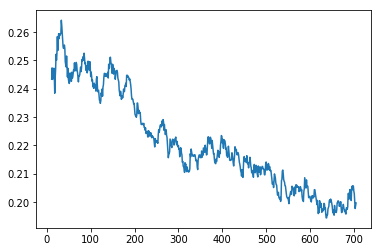

In [26]:
# Plot loss 
learn.sched.plot_loss()

In [27]:
# Save our model in models folder
# Looks like our model is overfitting the training data: 0.188023   0.234439   0.921935 
learn.save('224_resnext101_64_val')

In [28]:
# Load our trained model 
learn.load('224_resnext101_64_val')

In [30]:
#log_preds, y = learn.TTA()
#probs = np.exp(log_preds)
#accuracy_np(log_preds, y), metrics.log_loss(y, probs)

### Increase the size of images to improve accuracy

In [31]:
# Set image size to 299 and augment images and continue training 
learn.set_data(get_data(299, bs))

# Freeze all but the last layer
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [32]:
# Retrain our model only with the last layer 
%time learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.213106   0.228426   0.931034  
    1      0.20028    0.226494   0.923851                    
    2      0.182811   0.220885   0.931513                    

CPU times: user 15min 44s, sys: 1min 23s, total: 17min 7s
Wall time: 12min 12s


[0.22088483, 0.9315134121312035]

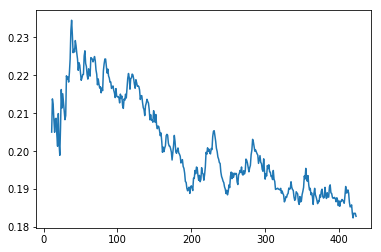

In [33]:
# Plot loss
learn.sched.plot_loss()

In [34]:
# Retrain our model with cycle_mult=2 eg SGDR is "multiples of 2" after each epoch. 
# First cycle 1 epochs
# Second cycle 2 epochs
# Third cycle 4 epochs 
# etc...
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.166797   0.221709   0.931034  
    1      0.16789    0.214504   0.93295                     
    2      0.152113   0.214498   0.931513                    
    3      0.15292    0.214286   0.92864                     
    4      0.148504   0.218831   0.929119                    
    5      0.12888    0.220096   0.927682                    
    6      0.117102   0.216962   0.929119                    

CPU times: user 37min 22s, sys: 3min 19s, total: 40min 42s
Wall time: 28min 39s


[0.21696238, 0.929118780626191]

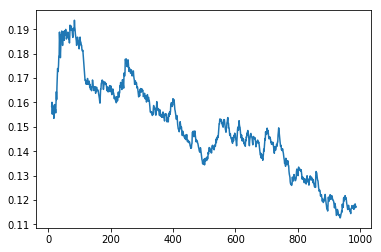

In [35]:
# Plot loss
learn.sched.plot_loss()

In [36]:
# Retrain again our model to see if training can still improve the model
%time learn.fit(1e-2, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.133266   0.220394   0.930077  
    1      0.116504   0.216861   0.92864                     

CPU times: user 11min 20s, sys: 59.9 s, total: 12min 20s
Wall time: 8min 14s


[0.2168609, 0.9286398457156287]

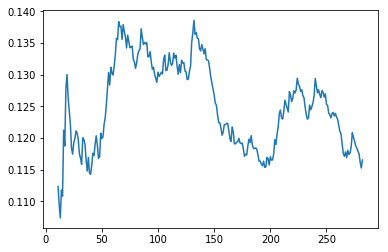

In [37]:
# Plot loss
learn.sched.plot_loss()

#### Our model didn't improve and starts to overfitting! Also loss function jumps whiout converging.

In [38]:
learn.save('299_resnext101_64_val')

### Retrain our model on all training data without train/split and images size of 299x299

In [39]:
# Set only one image for validation set  
# Our trn_loss  val_loss accuracy will be wrong, use it only with already defined model
val_idxs = [0]

In [40]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('299_resnext101_64_val')


# Get data without validation set and images 340x340 and bs 58
learn.set_data(get_data(299, bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 142/177 [03:19<00:49,  1.40s/it, loss=0.563]

In [ ]:
# Find the best learning rate for actual model
%time learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  3%|▎         | 5/177 [00:08<04:51,  1.69s/it, loss=0.138]  


Exception in thread Thread-40:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.193475   0.000617   1.0       
    1      0.169489   0.000246   1.0                         

CPU times: user 11min 42s, sys: 1min 1s, total: 12min 44s
Wall time: 8min 13s


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.141981   0.000241   1.0       
    1      0.142869   0.000804   1.0                         
    2      0.121736   0.000146   1.0                         
    3      0.137282   0.000272   1.0                         
    4      0.134897   0.00028    1.0                         

CPU times: user 30min 13s, sys: 2min 42s, total: 32min 55s
Wall time: 20min 50s


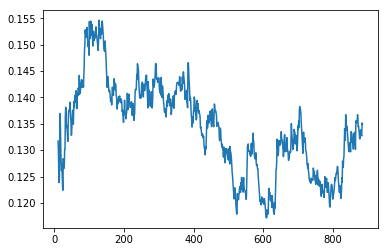

In [41]:
# Start training
%time learn.fit(1e-2, 2)
%time learn.fit(1e-2, 5, cycle_len=1)
learn.save('299_resnext101_64_no_val')

# Plot loss
learn.sched.plot_loss()

#### Again loss function jumps whiout converging.

### Retrain our model on all training data without train/split and images size of 340x340

In [42]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('299_resnext101_64_no_val')


# Get data without validation set and images 340x340 and bs 58
learn.set_data(get_data(340, bs))

CPU times: user 508 ms, sys: 28 ms, total: 536 ms
Wall time: 533 ms


In [43]:
# Find the best learning rate for actual model
%time learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 142/177 [04:22<01:04,  1.85s/it, loss=0.508]

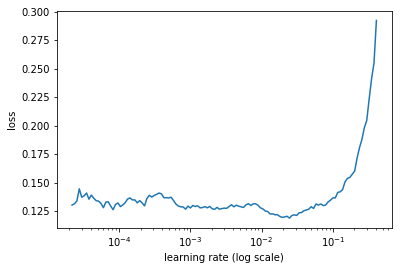

In [44]:
learn.sched.plot()

In [45]:
# Start training with lr=0.1, looking at our lr plot there is no difference betwen lr rates
%time learn.fit(1e-1, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 4/177 [00:09<07:00,  2.43s/it, loss=0.145]

Exception in thread Thread-49:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.136074   0.00057    1.0       

CPU times: user 7min 47s, sys: 45.7 s, total: 8min 33s
Wall time: 5min 25s


[0.00057029724, 1.0]

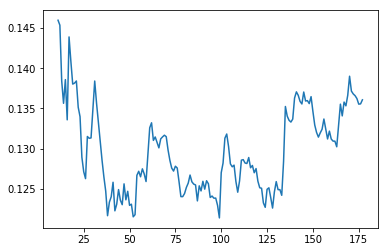

In [46]:
# Plot loss
learn.sched.plot_loss()

In [ ]:
#
# %time learn.fit(1e-1, 1, cycle_len=1, cycle_mult=2)

In [ ]:
# Plot loss
# learn.sched.plot_loss()

In [48]:
learn.save('340_resnext101_64_no_val')

### Make our prediction 340 x 340 using all training images

In [49]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('340_resnext101_64_no_val')

%time log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

CPU times: user 6min 15s, sys: 35.2 s, total: 6min 50s
Wall time: 5min 2s


(10357, 120)

In [50]:
# Convert to probs
preds = np.exp(log_preds_test)

ds = pd.DataFrame(preds)
ds.columns = data.classes

ds.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
ds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,6.308110e-09,6.374940e-08,7.288174e-09,8.841731e-09,5.241898e-10,3.804290e-09,9.286875e-10,4.449473e-09,4.724518e-10,...,2.538716e-10,1.166658e-09,4.856072e-09,1.173385e-09,5.176655e-08,2.973182e-10,6.316394e-09,9.084337e-09,1.105029e-09,7.990253e-11
1,6b423ca7020e70eb05732843c5d2bad1,6.362963e-08,8.115176e-07,8.139673e-08,1.444969e-08,1.078572e-08,1.115159e-09,1.483031e-09,1.083444e-08,6.999820e-08,...,2.071547e-09,7.541386e-09,1.223743e-10,2.097470e-08,7.314142e-10,1.740593e-08,8.234117e-07,1.157816e-08,9.061792e-08,3.227692e-09
2,74aa7e201e0e93e13e87b986a7d31839,4.018449e-07,3.169048e-07,6.883610e-07,3.620656e-04,6.272803e-08,9.918790e-07,2.450528e-07,5.534716e-08,3.733855e-07,...,1.217966e-07,2.331424e-06,6.389186e-07,2.301899e-06,2.355969e-07,1.651361e-06,2.365953e-06,6.467031e-06,1.074535e-02,2.132107e-07
3,a079f72193264bc5685e5d28d7372680,6.748815e-05,5.247355e-06,4.445840e-06,8.221328e-05,3.318830e-06,5.382947e-06,1.373285e-05,2.323232e-06,5.355220e-06,...,1.322719e-06,8.743870e-06,9.001964e-06,2.559548e-06,6.711079e-06,1.542577e-06,6.059137e-05,1.514627e-06,2.882727e-03,7.617762e-05
4,583f7580fa5fec1266331fcf83b76fd6,3.348483e-08,2.094643e-09,1.054395e-08,1.151300e-07,1.540020e-10,2.836048e-08,1.800089e-10,8.277088e-11,3.804230e-10,...,2.033158e-09,2.071577e-10,5.462156e-11,6.884482e-11,6.870948e-10,5.741800e-10,4.040493e-10,5.928793e-09,4.657206e-08,1.186698e-08


In [51]:
ds.to_csv(f'{PATH}340_resnext101_64_no_val_submission.csv', index=False)

### Make our prediction using 299_resnext101_64_no_val

In [52]:
learn.load('299_resnext101_64_no_val')
%time preds_299_noval = learn.predict(is_test=True)

CPU times: user 6min 24s, sys: 24.2 s, total: 6min 48s
Wall time: 5min 1s


In [54]:
preds = np.exp(preds_299_noval)
ds = pd.DataFrame(preds)
ds.columns = data.classes
ds.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
ds.to_csv(f'{PATH}299_resnext101_64_no_val_submission.csv', index=False)

### Make our prediction using 299_resnext101_64_val

In [ ]:
learn.load('299_resnext101_64_val')
%time preds_299_val = learn.predict(is_test=True)

In [ ]:
preds = np.exp(preds_299_val)
ds = pd.DataFrame(preds)
ds.columns = data.classes
ds.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
ds.to_csv(f'{PATH}299_resnext101_64_val_submission.csv', index=False)